In [43]:
import torch
print(torch.__version__)
print(torch.version.cuda)



2.5.1+cu118
11.8


In [45]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter # Removed .filters
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from scipy import ndimage, spatial
%matplotlib inline

In [53]:
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = len(gt)  # Number of ground truth points
    if gt_count == 0:
        return density

    # Extract coordinates from ground truth points
    pts = np.array([(int(pt[0]), int(pt[1])) for pt in gt])  # Each point as (x, y)
    leafsize = 2048
    # build kdtree
    tree = spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('Generating density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(density.shape, dtype=np.float32)
        pt2d[pt[1], pt[0]] = 1.0  # Set the point in the density map
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(density.shape)) / 4.0  # case: 1 point
        density += ndimage.gaussian_filter(pt2d, sigma, mode='constant')
    print('Density generation complete.')
    return density

In [47]:
root = r'D:\AI\CSRNet\CSRNet-pytorch\dataset'
train = os.path.join(root, 'train', 'images')
test = os.path.join(root, 'test', 'images')

In [48]:
img_paths = []
for path in [train, test]:
    img_paths.extend(glob.glob(os.path.join(path, '*.png')))

In [49]:
# To find keys in .h5 files
example_h5_path = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\train\ground_truth\20130320T004348.182606.Cam6_54.h5'
with h5py.File(example_h5_path, 'r') as f:
    print("Keys in .h5 file:", list(f.keys()))


Keys in .h5 file: ['density']


In [58]:
for img_path in img_paths:
    print(img_path)
    
    # Adjust the path to point to the correct `.h5` file
    if "hr" in img_path:
        h5_path = img_path.replace("hr.png", ".h5").replace("images", "ground_truth")
    else:
        h5_path = img_path.replace(".png", ".h5").replace("images", "ground_truth")
    
    # Check if the .h5 file exists
    if not os.path.exists(h5_path):
        print(f"File not found: {h5_path}")
        continue

    # Load coordinates and radius values
    with h5py.File(h5_path, 'r') as hf:
        if 'c-x' in hf.keys() and 'c-y' in hf.keys():
            gt_x = hf['c-x'][:].astype(np.float32)  # Ensure c-x values are floats
            gt_y = hf['c-y'][:].astype(np.float32)  # Ensure c-y values are floats
        if 'radius' in hf.keys():
            radii = hf['radius'][:].astype(np.float32)  # Ensure radius values are floats
            if np.isscalar(radii):  # If radii is a scalar, make it an array
                radii = np.full_like(gt_x, radii, dtype=np.float32)
            else:
                radii = np.full_like(gt_x, 10, dtype=np.float32)  # Default radius if not available
        else:
            print(f"No records found in: {h5_path}")
            continue

    # Read image and get shape
    img = plt.imread(img_path)
    img_shape = img.shape[:2]

    # Generate density map with a smooth gradient within each circle
    density_map = density_map_with_gradient(img_shape, gt_x, gt_y, radii, scale_radius=1.5)  # Adjust scale_radius as needed

    # Save the density map back to an .h5 file without overwriting other keys
    with h5py.File(h5_path, 'a') as hf:
        if 'density' in hf:
            del hf['density']  # Delete existing 'density' dataset
        hf.create_dataset('density', data=density_map)  # Add the new 'density' dataset

D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004348.182606.Cam6_54.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004348.754118.Cam6_13.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004349.135000.Cam6_11.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004349.516008.Cam6_43.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004351.992184.Cam6_61.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004352.373192.Cam6_51.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004352.754200.Cam6_23.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004353.135082.Cam6_53.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004353.706594.Cam6_22.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004354.849492.Cam6_52.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004355.801761.Cam6_12.png
D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004356.563776.Cam6

## Debugging

Is there a density map that matches its image?

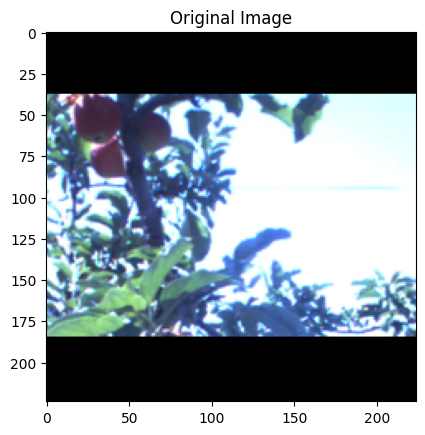

Keys in the .h5 file: ['#item', 'c-x', 'c-y', 'density', 'radius']
Using 'density' key.
Density map shape: (224, 224)
Density map sum: 0.9997966


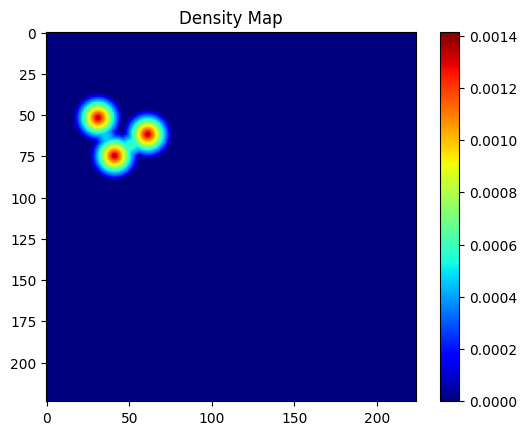

In [65]:
# Display the image
img_path = img_paths[48]  # Example: view the 8th image
plt.imshow(Image.open(img_path))
plt.title("Original Image")
plt.show()

# Define the path to the corresponding .h5 file
h5_path = img_path.replace('.png', '.h5').replace('images', 'ground_truth')

# Open and inspect the .h5 file
with h5py.File(h5_path, 'r') as gt_file:
    # List all keys in the .h5 file
    print("Keys in the .h5 file:", list(gt_file.keys()))

    # Check if 'density' or 'density_map' dataset exists
    if 'density' in gt_file:
        density_map = gt_file['density'][:]
        print("Using 'density' key.")
    elif 'density_map' in gt_file:
        density_map = gt_file['density_map'][:]
        print("Using 'density_map' key.")
    else:
        print("No 'density' or 'density_map' key found in the .h5 file.")
        density_map = None

    # Display the density map if it was found and has non-zero values
    if density_map is not None:
        print("Density map shape:", density_map.shape)
        print("Density map sum:", np.sum(density_map))  # Sum should be > 0 if there's data

        if np.sum(density_map) > 0:
            plt.imshow(density_map, cmap='jet')
            plt.colorbar()
            plt.title("Density Map")
            plt.show()
        else:
            print("The density map is empty.")

### Key's check for .h5

In [60]:
with h5py.File(h5_path, 'r') as hf:
    print("Keys in the .h5 file:", list(hf.keys()))


Keys in the .h5 file: ['#item', 'c-x', 'c-y', 'density', 'radius']


## .h5 verification

In [ ]:

# Path to the ground_truth folder for train
ground_truth_dir = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\train\ground_truth'

# Check each .h5 file in the directory
missing_density = []
for h5_file in os.listdir(ground_truth_dir):
    if h5_file.endswith(".h5"):
        h5_path = os.path.join(ground_truth_dir, h5_file)
        with h5py.File(h5_path, 'r') as f:
            if 'density' not in f:
                missing_density.append(h5_file)

if missing_density:
    print("The following files are missing the 'density' dataset:")
    for filename in missing_density:
        print(filename)
else:
    print("All .h5 files contain the 'density' dataset.")


All .h5 files contain the 'density' dataset.


In [ ]:
# Path to the ground_truth folder for test
ground_truth_dir = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\test\ground_truth'

# Check each .h5 file in the directory
missing_density = []
for h5_file in os.listdir(ground_truth_dir):
    if h5_file.endswith(".h5"):
        h5_path = os.path.join(ground_truth_dir, h5_file)
        with h5py.File(h5_path, 'r') as f:
            if 'density' not in f:
                missing_density.append(h5_file)

if missing_density:
    print("The following files are missing the 'density' dataset:")
    for filename in missing_density:
        print(filename)
else:
    print("All .h5 files contain the 'density' dataset.")

All .h5 files contain the 'density' dataset.
